# Classificació d'imatges amb CNN

En aquest notebook, es mostra com classificar imatges amb una xarxa neuronal convolucional (CNN). Veurem també quin seria el rendiment d'una xarxa neuronal feedforward (FNN) en aquest mateix problema.

## Instal·lació de l'entorn

En primer lloc, instal·lem les llibreries necessàries per a executar el codi. En el nostre cas, necessitarem `keras`.

In [3]:
%pip install keras_cv keras tensorflow opencv-python-headless

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.1/803.1 kB 17.6 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 924.6/924.6 kB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.0/777.0 kB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 42.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.4/126.4 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 44.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.9/152.9 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.7/240.7 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.5/126.5 kB

Ara importarem les llibreries necessàries per a fer classificació d'imatges utilitzant xarxes neuronals feed forward.

In [4]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.layers.experimental.preprocessing import Rescaling

import matplotlib.pyplot as plt
import numpy as np

from PIL import Image

Utilitzarem keras per a construir la xarxa neuronal (de fons utilitza tensorflow) i per a carregar el conjunt de dades.

## Preparem les dades

Com ja sabem, el rendiment de les xarxes neuronals _Feed Forward_ (FNN) en tasques de classificació d'imatges no és gaire bo. Això és degut a que les xarxes FNN no són capaces de capturar les relacions espacials entre els píxels de la imatge. Així i tot, començarem amb una xarxa FNN per a veure quin és el rendiment que podem obtenir.

Com a _DataSet_, utilitzarem el conjunt de dades `cats_vs_dogs` que obtindrem a continuació. Aquest conjunt de dades conté 25.000 imatges en color de 224x224 píxels, amb 2 classes diferents: 'Cat' i 'Dog'.

Son petites, però suficients per a mostrar com funcionen les xarxes neuronals en tasques de classificació d'imatges.

Comencem carregant descarregantv el zip en el datatset i descomprimint-lo.

In [3]:
import os, zipfile
if not os.path.exists('data/kagglecatsanddogs_5340.zip'):
    !wget -P data https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

if not os.path.exists('data/PetImages'):
    with zipfile.ZipFile('data/kagglecatsanddogs_5340.zip', 'r') as zip_ref:
        zip_ref.extractall('data')

--2024-03-20 18:52:31--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.1.101.207, 2600:1406:4400:2a5::317f, 2600:1406:4400:2af::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.1.101.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘data/kagglecatsanddogs_5340.zip’

kagglecatsanddogs_5 100%[===================>] 786.67M  70.4MB/s    in 10s     

2024-03-20 18:52:41 (78.4 MB/s) - ‘data/kagglecatsanddogs_5340.zip’ saved [824887076/824887076]



En següent lloc haurem de verificar que les dades estiguen en el format correcte per poder ser evaluades, ja que moltes vegades les dades ens arriben corruptes o en problemes de compressió.

In [4]:
import glob

def check_image(fn):
    try:
        im = Image.open(fn)
        im.verify()
        print(im.format)
        return im.format=='JPEG'
    except Exception as e:
        print(e)
        return False

def check_image_dir(path):
    for fn in glob.glob(path):
        if not check_image(fn):
            print("Corrupt image or wrong format: {}".format(fn))
            os.remove(fn)

check_image_dir('data/PetImages/Cat/*.jpg')
check_image_dir('data/PetImages/Dog/*.jpg')

Streaming output truncated to the last 5000 lines.
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
BMP
Corrupt image or wrong format: data/PetImages/Cat/2189.jpg
JPEG
JPEG
JPEG
JPEG
BMP
Corrupt image or wrong format: data/PetImages/Cat/4334.jpg
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPE

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Streaming output truncated to the last 5000 lines.
Corrupt image or wrong format: data/PetImages/Dog/6238.jpg
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
BMP
Corrupt image or wrong format: data/PetImages/Dog/11253.jpg
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
JPEG
J

Ara haurem de crear un Dataset amb les dades obteses del Zip. Com estem utilitzant Keras ens aprofitarem de la funció `image_dataset_from_directory` que ens permet crear un `Lazy Dataset` automàticament.

Aquest `Lazy Dataset` ens permetrà carregar les imatges poc a poc; sense sobrecarregar la memòria. També anirà etiquetat auntomàticament, amb el nom de les carpetes contenedores.


In [5]:
data_dir = 'data/PetImages'
batch_size = 64
ds_train = keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = 'training',
    seed = 13,
    image_size = (224,224),
    batch_size = batch_size
)

ds_test = keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = 'validation',
    seed = 13,
    image_size = (224,224),
    batch_size = batch_size
)


Found 24769 files belonging to 2 classes.
Using 19816 files for training.
Found 24769 files belonging to 2 classes.
Using 4953 files for validation.


Vejam que les classes s'ha aplicat i algunes de les imatges.

In [6]:
class_names = ds_train.class_names
print(class_names)

['Cat', 'Dog']


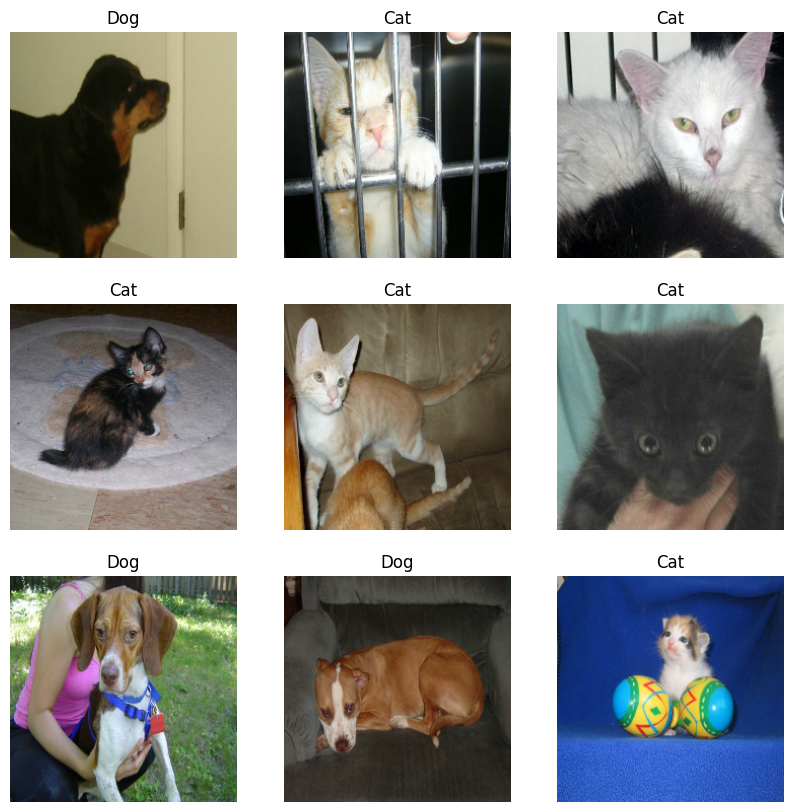

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in ds_train.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


## Xarxes neuronals feed forward

### Creem el model

Ara crearem el model de xarxa neuronal. Començarem amb una xarxa feed forward. Aquesta xarxa tindrà una capa d'entrada, dues capes ocultes i una capa de sortida.

La capa d'entrada tindrà 224x224x3 = 50176 neurones, ja que les imatges tenen 224x224 píxels i tres canals de color (RGB).

Per triar les dimensions de les capes ocultes, hem de tenir en compte que les imatges són petites i que volem que el model sigui lleuger. Així i tot, volem que el model sigui prou gran com per a capturar les relacions espacials entre els píxels de les imatges. Per això, triarem dues capes ocultes amb 1024 i 512 neurones, respectivament.

La capa de sortida tindrà 10 neurones, ja que hi ha 10 classes diferents. Utilitzarem la funció d'activació `softmax` per a obtenir les probabilitats de pertànyer a cada classe.

In [24]:
model = Sequential([
    Rescaling(1./255, input_shape=(224, 224, 3)), # Normalitzem les dades. El valor de cada color en cada pixel quedarà entre 0 i 1
    Flatten(), # Utilitzem la capa Flatten per convertir les imatges en vectors
    Dense(1024, activation='relu'), # Capa oculta amb 64 neurones i funció d'activació relu.
    Dense(512, activation='relu'), # Capa oculta amb 64 neurones i funció d'activació relu.
    Dense(1, activation='sigmoid') # Capa de sortida amb 1 neurona i funció d'activació sigmoide.
])

### Entrenem el model

Ara entrenarem el model. Per a fer-ho, primer hem de compilar-lo. Utilitzarem l'optimitzador `adam` i la funció de pèrdua `sparse_categorical_crossentropy`. A més, monitoritzarem l'exactitud del model durant l'entrenament.

Un cop compilat el model, l'entrenarem durant 100 èpoques. Utilitzarem un lot de 32 imatges (batch size).

In [25]:
# Compilació del model. Utilitzem l'optimitzador Adam, la funció de pèrdua binary_crossentropy i la mètrica accuracy.

model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

# Entrenament del model. Utilitzem 10 èpoques i un lot de 128 mostres.
history = model.fit(ds_train, epochs=10, batch_size=128, validation_data=(ds_test))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 flatten_3 (Flatten)         (None, 150528)            0         
                                                                 
 dense_7 (Dense)             (None, 1024)              154141696 
                                                                 
 dense_8 (Dense)             (None, 512)               524800    
                                                                 
 dense_9 (Dense)             (None, 1)                 513       
                                                                 
Total params: 154667009 (590.01 MB)
Trainable params: 154667009 (590.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/

Com podem veure, no hem aconsseguit gran cosa, ja que el `val_accuracy` apenes passa del 50% (tenient dues classes és equivalent al que tindriem triant a cegues).

Graficarem les dades de l'entrenament per veure-ho més clar.

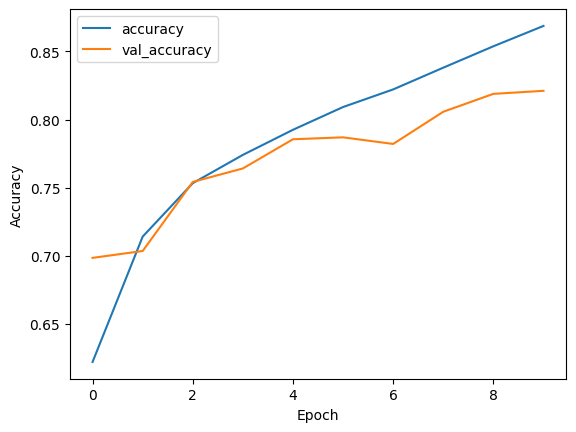

In [9]:
# Mostrem la pèrdua i l'accuracy del model durant l'entrenament.

def plot_history(history):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    plt.legend()
    plt.show()

plot_history(history)

Podem veure com, en cap moment hem pogut començar a millorar en les nostres prediccions.

Les xarxes neuronals feed forward no són capaces de capturar les relacions espacials entre els píxels de les imatges. Això fa que siguin molt fàcils de sobreajustar, com hem vist. HAurem de provar amb una xarxa neuronal convolucional (CNN) per a veure si podem millorar el rendiment.

## Xarxes neuronals convolucionals (CNN)

De cara a la pràctica, la diferència més gran en la construcció de la xarxa neuronal és que afegirem capes convolucionals i de _pooling_.

Les capes convolucionals són capaces de capturar les relacions espacials entre els píxels de la imatge. Això és el que fa que les CNN siguin molt més eficients que les FNN en tasques de classificació d'imatges.

Les capes de _pooling_ són capaces de reduir la mida de les imatges, mantenint-ne les característiques més importants. Això baixa el nombre de paràmetres de la xarxa i fa que sigui més lleugera.

A més, afegirem capes de _dropout_ per a reduir l'overfitting.

### Creem el model

Ara crearem el model de xarxa neuronal convolucional. Aquesta xarxa tindrà una capa d'entrada, una capa convolucional, una capa densa i una capa de sortida.

A continuació l'entrenarem i veurem com es comporta.


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 9)       684       
                                                                 
 flatten_4 (Flatten)         (None, 435600)            0         
                                                                 
 dense_10 (Dense)            (None, 1)                 435601    
                                                                 
Total params: 436285 (1.66 MB)
Trainable params: 436285 (1.66 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
310/310 [==============================] - 38s 118ms/step - loss: 0.9336 - accuracy: 0.5390 - val_loss: 0.6779 - val_accuracy: 0.5807
Epoch

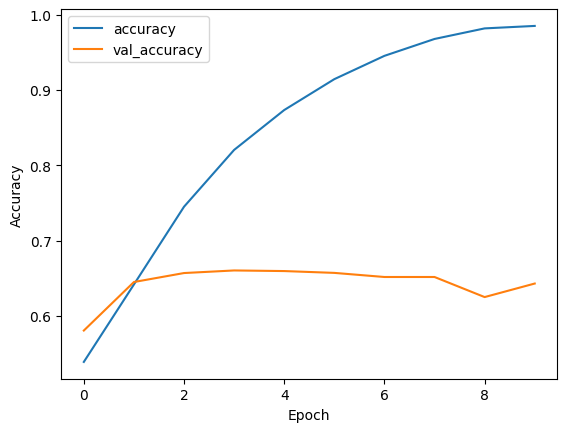

In [27]:
model = Sequential(
    [
        Rescaling(1./255, input_shape=(224, 224, 3)),
        Conv2D(filters=9, kernel_size=(5,5), activation='relu'),
        Flatten(),
        Dense(1, activation='sigmoid')
    ]
)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

history = model.fit(ds_train, epochs=10, batch_size=128, validation_data=ds_test)

plot_history(history)

Podem veure com solament amb una capa convolucional i una capa densa el resultat ja es prou millor que amb la xarxa feed forward. Es obvi com ja es comencen a identificar patrons que identifiquen a gossos i gats, encara que en trobat amb _overfitting_: a partir de la tercera época el `loss` baixa de forma decidida pero el `val_loss` comença a pujar. Per altra banda l'`accuracy` puja i el `val_accuracy` es queda estancat.

Això és degut a que la xarxa és molt petita. Haurem d'apilar més capes convolucionals i de _pooling_ per a millorar el rendiment.

La primera capa convolucional capta patrons bàsics com línies i corbes. Si agreguem més capes convolucionals, aquestes podran capturar patrons més complexos com formes `bàsiques` i, finalment, l'objecte que volem classificar. També augmentarem el nombre de `filters` conforme anem afegint capes convolucionals, ja que conforme els patrons es compliquen hi haurà més possible combinacions de característiques interessants que caldrà capturar.

Per facilitar aquest procés, utilitzarem una tècnica molt útil: reduir el tamany espacial de les imatges. Si hem detectat que en una finestra de `3x3` hi ha una característica important, no ens importa si aquesta característica està en la part superior o inferior de la imatge. Així que podem reduir la mida de la imatge a la meitat. Això és el que fa la capa de _pooling_.

Hi ha dos tipus de _pooling_: _max pooling_ i _average pooling_. El _max pooling_ agafa el valor màxim de la finestra i l'_average pooling_ en fa la mitjana. En general, el _max pooling_ funciona millor que l'_average pooling_.

L'estructura bàsica serà la de capa convolucional, capa de _pooling_ i capa de _dropout_. La capa de _dropout_ és molt útil per a reduir l'overfitting.

Vejam com es comporta la xarxa amb aquesta nova estructura.

In [8]:
model = Sequential(
    [
        Rescaling(1./255, input_shape=(224, 224, 3)),
        Conv2D(filters=10, kernel_size=(5,5), activation='relu', padding='same'),
        MaxPooling2D(),
        Dropout(0.2),
        Conv2D(filters=20, kernel_size=(5,5), activation='relu', padding='same'),
        MaxPooling2D(),
        Dropout(0.2),
        Conv2D(filters=40, kernel_size=(5,5), activation='relu', padding='same'),
        MaxPooling2D(),
        Dropout(0.2),
        Flatten(),
        Dense(1, activation='sigmoid')
    ]
)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

history = model.fit(ds_train, epochs=10, batch_size=128, validation_data=ds_test)

plot_history(history)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 10)      760       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 10)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 112, 112, 10)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 20)      5020      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 20)        0         
 g2D)                                                   

NameError: name 'plot_history' is not defined

Com podem veure, el rendiment de la xarxa ha millorat prou. Encara hi ha molt marge de millora, ara, però, no tenim un overfitting destacable i seria possible seguir afegint capes convolucionals i de _pooling_ per a millorar el rendiment.

De tota manera anem a veure una altra técnica: _data augmentation_ aplicarem una série de filtres a les imatges (escalats i rotacions) per dversificar les dades d'entrada i, per tant ajudar a la xarxa a generalitzar-se.

Ho podeu execurae per veure el resultat. Es possible, però, que necessite més de 10 époques per convergir.

In [12]:
from keras_cv.layers import RandAugment

model = Sequential(
    [
        Rescaling(1./255, input_shape=(224, 224, 3)),
        RandAugment(value_range=(0, 255), augmentations_per_image=1, magnitude=0.5),
        Conv2D(filters=10, kernel_size=(5,5), activation='relu', padding='same'),
        MaxPooling2D(),
        Dropout(0.2),
        Conv2D(filters=20, kernel_size=(5,5), activation='relu', padding='same'),
        MaxPooling2D(),
        Dropout(0.2),
        Conv2D(filters=40, kernel_size=(5,5), activation='relu', padding='same'),
        MaxPooling2D(),
        Dropout(0.2),
        Flatten(),
        Dense(1, activation='sigmoid')
    ]
)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

history = model.fit(ds_train, epochs=10, batch_size=128, validation_data=ds_test)

plot_history(history)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 rand_augment_2 (RandAugmen  (None, 224, 224, 3)       0         
 t)                                                              
                                                                 
 conv2d_9 (Conv2D)           (None, 224, 224, 10)      760       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 112, 112, 10)      0         
 g2D)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 112, 112, 10)      0         
                                                                 
 conv2d_10 (Conv2D)          (None, 112, 112, 20)     

KeyboardInterrupt: 

## Xarxes neuronals convolucionals (CNN) pre-entrenades

Com haurem vist, entrenar una xarxa neuronal convolucional des de zero és una tasca molt costosa. Això és degut a que les xarxes neuronals convolucionals tenen molts paràmetres i entrenar-les requereix moltes dades i temps.

Afortunadament, podem utilitzar xarxes neuronals convolucionals pre-entrenades. Això ens estalvia molt temps i recursos.

Veurem com afinar una xarxa neuronal convolucional pre-entrenada per a que classifique les nostres dades.



Com a exemple, utilitzarem la xarxa `VGG16` pre-entrenada. Aquesta xarxa ha estat entrenada amb el conjunt de dades `ImageNet`, que conté més de 14 milions d'imatges i 1000 classes diferents.

In [2]:
from keras.applications import VGG16

model = Sequential([
    Rescaling(1./255, input_shape=(224, 224, 3)),
    VGG16(include_top=False),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

model.layers[1].trainable = False

optimizer = keras.optimizers.Adam(learning_rate=0.00001)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

history = model.fit(ds_train, epochs=10, batch_size=128, validation_data=ds_test)

plot_history(history)

2024-03-20 23:18:39.729683: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-20 23:18:39.795539: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-20 23:18:40.101696: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-20 23:18:40.104450: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-20 23:18:40.811635: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

NameError: name 'Sequential' is not defined

El resultat ara és molt millor. Això és degut a que hem pogut utilitzar les característiques apreses per la xarxa pre-entrenada per a classificar les imatges.

El _transfer learning_ és molt útil quan no tenim moltes dades o quan no tenim molts recursos per a entrenar una xarxa neuronal convolucional des de zero.

## Utilització en OpenCV

Per a utilitzar la xarxa neuronal convolucional pre-entrenada en OpenCV hauriem de convertir la xarxa a un format que OpenCV pugui llegir. Això és una mica complicat, però es pot fer. De tota manera en aquesta secció veurem com cridar al model de Keras des de OpenCV.

In [1]:
import cv2

def load_image(path):
    img = cv2.imread(path)
    img = cv2.resize(img, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def predict_image(model, path):
    img = load_image(path)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0
    pred = model.predict(img)
    return pred

def predict_image_class(model, path):
    pred = predict_image(model, path)
    return class_names[np.argmax(pred)]

def predict_image_prob(model, path):
    pred = predict_image(model, path)
    return np.max(pred)

print(predict_image_class(model, 'data/PetImages/Cat/1.jpg'))

NameError: name 'model' is not defined